# GAN for Pokèmon generation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import FloatTensor
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.utils as vutils
from torch.utils import data
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image
import os
import sys
import time
import numpy as np
import random
import imageio
from pathlib import Path

# HYPERPARAMETERS

In [2]:
dataroot = "../input/mgan-dataset-poke/mgan_dataset"
checkpoint_file = "../output/checkpoint.pt"
image_path = '../working/'
dataset_name = 'Pokemons'
nc = 3                    # number of channel
img_size = (64,64,nc)
batch_size = 64 
lr = 2e-4
betas = (.5, .99)
epochs = 100
ngpu = 1
weights_backup = False  #Save weights during training
weights_restore = False #Set to False if want to restart training from zero

nz = 128 #size of latent z vector
ngf = 64 #number of generator filters
ndf = 64 #number of discriminator filters

real_label = 1
fake_label = 0

# DATALOADER

Dataset Pokemons contains 14774 images


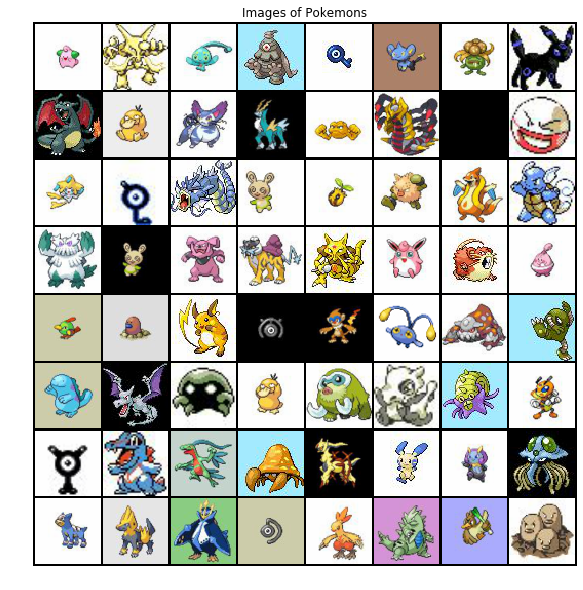

In [3]:
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size[0]),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Images of {}".format(dataset_name))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

print('Dataset {} contains {} images'.format(dataset_name, len(dataset)))

# MODELS

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

""" GENERATOR"""
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.nz = nz 
        self.layer1 = nn.Sequential(
            # Input size : input latent vector 'z' with dimension (nz)*1*1
            # Output size: output feature vector with (ngf*8)*4*4
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf*8, kernel_size = 4, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            # Input size : input feature vector with (ngf*8)*4*4
            # Output size: output feature vector with (ngf*4)*8*8
            nn.ConvTranspose2d(in_channels = ngf*8, out_channels = ngf*4, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True)
        )

        self.layer3 = nn.Sequential(
            # Input size : input feature vector with (ngf*4)*8*8
            # Output size: output feature vector with (ngf*2)*16*16
            nn.ConvTranspose2d(in_channels = ngf*4, out_channels = ngf*2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True)
        )

        self.layer4 = nn.Sequential(
            # Input size : input feature vector with (ngf*2)*16*16
            # Output size: output feature vector with (ngf)*32*32
            nn.ConvTranspose2d(in_channels = ngf*2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )

        self.layer5 = nn.Sequential(
            # Input size : input feature vector with (ngf)*32*32
            # Output size: output image with (nChannels)*(image width)*(image height)
            nn.ConvTranspose2d(in_channels = ngf, out_channels = nc, kernel_size =4, stride = 2, padding = 1, bias = False),
            nn.Tanh() # To restrict each pixels of the fake image to 0~1
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        return out

    def sample_latent(self, num_samples):
        return Variable(torch.randn(num_samples, self.nz, 1, 1, device=device))

""" DISCRIMINATOR"""

class Discriminator(nn.Module):
    def __init__(self, ndf, nc):
        super(Discriminator, self).__init__()
        # input : (batch * nChannels * image width * image height)
        self.layer1 = nn.Sequential(
            # Input size : input image with dimension (nChannels)*64*64
            # Output size: output feature vector with (ndf)*32*32
            nn.Conv2d(in_channels = nc, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True))

        self.layer2 = nn.Sequential(
            # Input size : input feature vector with (ndf)*32*32
            # Output size: output feature vector with (ndf*2)*16*16
            nn.Conv2d(in_channels = ndf, out_channels = ndf*2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True))

        self.layer3 = nn.Sequential(
            # Input size : input feature vector with (ndf*2)*16*16
            # Output size: output feature vector with (ndf*4)*8*8
            nn.Conv2d(in_channels = ndf*2, out_channels = ndf*4, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True))

        self.layer4 = nn.Sequential(
            # Input size : input feature vector with (ndf*4)*8*8
            # Output size: output feature vector with (ndf*8)*4*4
            nn.Conv2d(in_channels = ndf*4, out_channels = ndf*8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True))

        self.layer5 = nn.Sequential(
            # Input size : input feature vector with (ndf*8)*4*4
            # Output size: output probability of fake/real image
            nn.Conv2d(in_channels = ndf*8, out_channels = 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
            # nn.Sigmoid() -- Replaced with Least Square Loss
            )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        return out.view(-1,1)

# GAN

In [5]:
class GAN():
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer, g_scheduler, d_scheduler,
                 critic_iterations=2):
      
        self.G = generator
        self.G_opt = gen_optimizer
        self.D = discriminator
        self.D_opt = dis_optimizer
        self.losses = {'G': [], 'D': []}
        self.start_epoch = 0
        self.critic_iterations = critic_iterations
        self.training_progress_images = []
        self.D_scheduler = d_scheduler
        self.G_scheduler = g_scheduler
        self.fixed_z =  self.G.sample_latent(batch_size)

    def _critic_train_iteration(self, data):

        #Loss on real data
        self.D.zero_grad()
        data = data.to(device)
        batch_size = data.size(0)      
        label = torch.full((batch_size,), real_label, device=device) 
        out_real = self.D(data)
        d_real = 0.5 * torch.mean((out_real-label)**2) # criterion(output, label)
        d_real.backward()
        # Loss on generated data
        generated_data = self.sample_generator(batch_size)
        label.fill_(fake_label)
        out_generated = self.D(generated_data)
        d_fake = 0.5 * torch.mean((out_generated-label)**2) # criterion(output, label)        
        d_fake.backward()
        # Create total loss and optimize
        d_loss = d_fake + d_real
        self.D_opt.step()
        # Record loss
        self.losses['D'].append(d_loss.data.item())
    
    def _generator_train_iteration(self, data):
        
        self.G.zero_grad()
        # Get generated data
        batch_size = data.to(device).size(0)
        generated_data = self.sample_generator(batch_size)
        label = torch.full((batch_size,), real_label, device=device)
        # Calculate loss and optimize
        out_generated = self.D(generated_data)
        g_loss = 0.5 * torch.mean((out_generated - label)**2) # criterion(output, label)
        g_loss.backward()
        self.G_opt.step()
        # Record loss
        self.losses['G'].append(g_loss.data.item())

    def train_epoch(self,dataloader, epoch):

        for i, (data, _) in enumerate(dataloader):
            #Train first Discriminator for n iteration
            for _ in range(self.critic_iterations):
                self._critic_train_iteration(data)
            #Train generator
            self._generator_train_iteration(data)

        #self.D_scheduler.step()
        #self.G_scheduler.step()

        print("Epoch[%d/%d]\tD_loss: %.2f,\tG_loss: %.2f" % (epoch, epochs, self.losses['D'][-1], self.losses['G'][-1]) )
        
    def train(self, dataloader, epochs, checkpoint_file):
      
        if weights_restore:
            self.restore_checkpoint(checkpoint_file)
         
        print('###########   TRAINING STARTED  ############')
        start = time.time()

        for epoch in range(epochs-self.start_epoch):
            epoch+=self.start_epoch

            self.train_epoch(dataloader, epoch)    
            
            if weights_backup and epoch % 2 == 0:
                self.store_checkpoint(epoch, checkpoint_file)

            #Save a checkpoint also at half of the training
            if weights_backup and epoch == (int(epochs/2)):
                self.store_checkpoint(epoch, checkpoint_file)
            
            if epoch % 20 == 0:
                self.evaluate(epoch)
                
        end = time.time()
        print('Total training time: {} min, {} sec '.format(int((end - start) / 60), int((end - start) % 60)))
      
        #Save and Plot final results
        imageio.mimsave(image_path+'_GIF_{}epochs.gif'.format(epochs),self.training_progress_images) #Save GIF
        self.plot_save_generated(epoch, save=True)
        self.plot_save_losses()
    
    def sample_generator(self, num_samples):
        z_samples = self.G.sample_latent(num_samples)
        generated_data = self.G(z_samples)
        return generated_data

    def evaluate(self, epoch):
        img_grid = make_grid(self.G(self.fixed_z).cpu().data, normalize=True).numpy()   # Generate batch of images and convert to grid
        img_grid = img_grid.transpose((1, 2, 0))     # Convert to numpy and transpose axes to fit imageio convention i.e. (width, height, channels)
        self.training_progress_images.append(img_grid)                  # Add image grid to training progress        
        plt.figure(figsize=(7,7))
        plt.imshow(img_grid)
        plt.axis('off')
        plt.title('Generated images after epoch {}'.format((epoch+1)))
        plt.show()

    def plot_save_generated(self, epoch=epochs, save=False):
        img = make_grid(self.sample_generator(64).cpu().data,normalize=True).numpy() 
        img = img.transpose((1, 2, 0)) 
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Generated images after {} epochs'.format((epoch+1)))
        if save:
            plt.savefig(image_path + '_generated_%d.png' % (epoch+1))
        plt.show()
     
    def generate_pokemons(self, n=64):
        img = make_grid(self.sample_generator(n).cpu().data,normalize=True).numpy() 
        img = img.transpose((1, 2, 0)) 
        plt.figure(figsize=(15,15))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Generated Pokèmons')
        plt.show()
    
    def plot_save_losses(self):
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Losses During Training")
        plt.plot(self.losses['G'],label="G")
        plt.plot(self.losses['D'],label="D")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(image_path + '_losses.png')
        plt.show()

    def store_checkpoint(self, epoch, checkpoint_file):
        torch.save({'epoch': epoch,
                  'generator': self.G.state_dict(),
                  'discriminator': self.D.state_dict(),
                  'optimizerG': self.G_opt.state_dict(),
                  'optimizerD': self.D_opt.state_dict(),
                  'loss': self.losses,
                  'fixed_z': self.fixed_z,
                  'images_gen': self.training_progress_images
                  }, checkpoint_file)
        print('Saved checkpoint at epoch: ', epoch)

    def restore_checkpoint(self,checkpoint_file):
        if Path(checkpoint_file).exists():
            checkpoint = torch.load(checkpoint_file)
            self.G.load_state_dict(checkpoint['generator'])
            self.D.load_state_dict(checkpoint['discriminator'])
            self.G_opt.load_state_dict(checkpoint['optimizerG'])
            self.D_opt.load_state_dict(checkpoint['optimizerD'])
            self.losses = checkpoint['loss']
            self.fixed_z = checkpoint['fixed_z']
            self.training_progress_images = checkpoint['images_gen']
            self.start_epoch = checkpoint['epoch']
            print('Checkpoint found and restored at epoch {}'.format(self.start_epoch))
        else: 
            print('Checkpoint not used or not exist\n')

# MAIN

###########   TRAINING STARTED  ############
Epoch[0/100]	D_loss: 0.13,	G_loss: 0.14


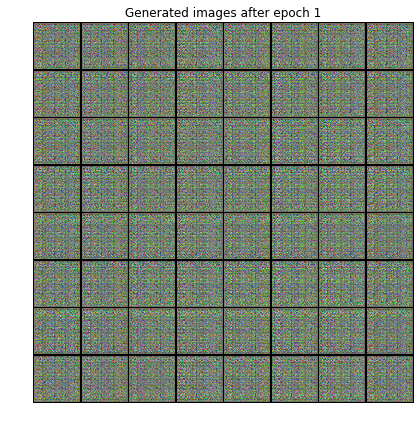

Epoch[1/100]	D_loss: 0.06,	G_loss: 0.44
Epoch[2/100]	D_loss: 0.06,	G_loss: 0.56
Epoch[3/100]	D_loss: 0.11,	G_loss: 0.14
Epoch[4/100]	D_loss: 0.05,	G_loss: 0.38
Epoch[5/100]	D_loss: 0.04,	G_loss: 0.60
Epoch[6/100]	D_loss: 0.01,	G_loss: 0.49
Epoch[7/100]	D_loss: 0.16,	G_loss: 0.24
Epoch[8/100]	D_loss: 0.01,	G_loss: 0.47
Epoch[9/100]	D_loss: 0.02,	G_loss: 0.38
Epoch[10/100]	D_loss: 0.00,	G_loss: 0.49
Epoch[11/100]	D_loss: 0.00,	G_loss: 0.56
Epoch[12/100]	D_loss: 0.14,	G_loss: 0.46
Epoch[13/100]	D_loss: 0.11,	G_loss: 0.33
Epoch[14/100]	D_loss: 0.08,	G_loss: 0.51
Epoch[15/100]	D_loss: 0.08,	G_loss: 0.75
Epoch[16/100]	D_loss: 0.09,	G_loss: 0.37
Epoch[17/100]	D_loss: 0.11,	G_loss: 0.14
Epoch[18/100]	D_loss: 0.08,	G_loss: 0.28
Epoch[19/100]	D_loss: 0.04,	G_loss: 0.48
Epoch[20/100]	D_loss: 0.13,	G_loss: 0.81


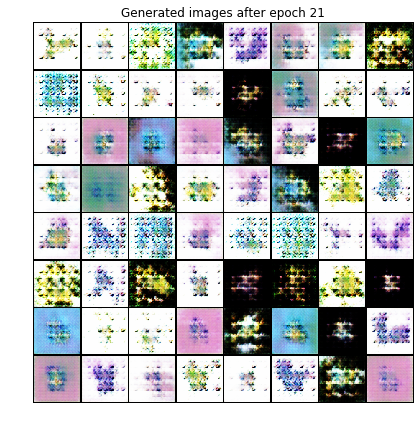

Epoch[21/100]	D_loss: 0.02,	G_loss: 0.24
Epoch[22/100]	D_loss: 0.06,	G_loss: 0.32
Epoch[23/100]	D_loss: 0.08,	G_loss: 0.72
Epoch[24/100]	D_loss: 0.08,	G_loss: 0.35
Epoch[25/100]	D_loss: 0.07,	G_loss: 0.49
Epoch[26/100]	D_loss: 0.05,	G_loss: 0.42
Epoch[27/100]	D_loss: 0.04,	G_loss: 0.65
Epoch[28/100]	D_loss: 0.04,	G_loss: 0.68
Epoch[29/100]	D_loss: 0.15,	G_loss: 0.09
Epoch[30/100]	D_loss: 0.05,	G_loss: 0.48
Epoch[31/100]	D_loss: 0.06,	G_loss: 0.19
Epoch[32/100]	D_loss: 0.03,	G_loss: 0.44
Epoch[33/100]	D_loss: 0.05,	G_loss: 0.35
Epoch[34/100]	D_loss: 0.07,	G_loss: 0.91
Epoch[35/100]	D_loss: 0.03,	G_loss: 0.73
Epoch[36/100]	D_loss: 0.03,	G_loss: 0.58
Epoch[37/100]	D_loss: 0.06,	G_loss: 0.45
Epoch[38/100]	D_loss: 0.04,	G_loss: 0.54
Epoch[39/100]	D_loss: 0.02,	G_loss: 0.32
Epoch[40/100]	D_loss: 0.05,	G_loss: 0.56


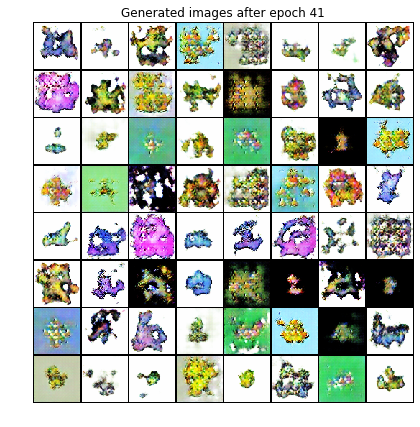

Epoch[41/100]	D_loss: 0.15,	G_loss: 0.17
Epoch[42/100]	D_loss: 0.03,	G_loss: 0.45
Epoch[43/100]	D_loss: 0.08,	G_loss: 0.58
Epoch[44/100]	D_loss: 0.09,	G_loss: 0.32
Epoch[45/100]	D_loss: 0.03,	G_loss: 0.81
Epoch[46/100]	D_loss: 0.05,	G_loss: 0.31
Epoch[47/100]	D_loss: 0.04,	G_loss: 0.39
Epoch[48/100]	D_loss: 0.08,	G_loss: 0.32
Epoch[49/100]	D_loss: 0.02,	G_loss: 0.35
Epoch[50/100]	D_loss: 0.02,	G_loss: 0.72
Epoch[51/100]	D_loss: 0.03,	G_loss: 0.54
Epoch[52/100]	D_loss: 0.04,	G_loss: 0.52
Epoch[53/100]	D_loss: 0.05,	G_loss: 0.59
Epoch[54/100]	D_loss: 0.03,	G_loss: 0.41
Epoch[55/100]	D_loss: 0.02,	G_loss: 0.50
Epoch[56/100]	D_loss: 0.07,	G_loss: 0.57
Epoch[57/100]	D_loss: 0.03,	G_loss: 0.45
Epoch[58/100]	D_loss: 0.03,	G_loss: 0.41
Epoch[59/100]	D_loss: 0.01,	G_loss: 0.46
Epoch[60/100]	D_loss: 0.04,	G_loss: 0.69


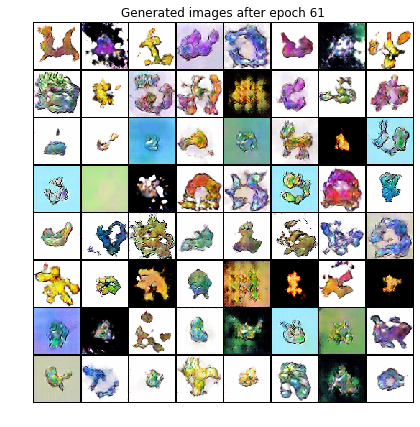

Epoch[61/100]	D_loss: 0.11,	G_loss: 0.72
Epoch[62/100]	D_loss: 0.10,	G_loss: 0.67
Epoch[63/100]	D_loss: 0.03,	G_loss: 0.50
Epoch[64/100]	D_loss: 0.02,	G_loss: 0.44
Epoch[65/100]	D_loss: 0.02,	G_loss: 0.58
Epoch[66/100]	D_loss: 0.03,	G_loss: 0.58
Epoch[67/100]	D_loss: 0.02,	G_loss: 0.47
Epoch[68/100]	D_loss: 0.06,	G_loss: 0.75
Epoch[69/100]	D_loss: 0.14,	G_loss: 0.67
Epoch[70/100]	D_loss: 0.03,	G_loss: 0.62
Epoch[71/100]	D_loss: 0.02,	G_loss: 0.56
Epoch[72/100]	D_loss: 0.01,	G_loss: 0.42
Epoch[73/100]	D_loss: 0.02,	G_loss: 0.33
Epoch[74/100]	D_loss: 0.03,	G_loss: 0.42
Epoch[75/100]	D_loss: 0.02,	G_loss: 0.57
Epoch[76/100]	D_loss: 0.11,	G_loss: 0.26
Epoch[77/100]	D_loss: 0.01,	G_loss: 0.54
Epoch[78/100]	D_loss: 0.03,	G_loss: 0.39
Epoch[79/100]	D_loss: 0.02,	G_loss: 0.34
Epoch[80/100]	D_loss: 0.02,	G_loss: 0.55


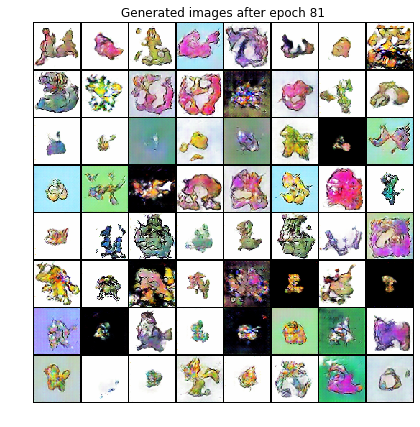

Epoch[81/100]	D_loss: 0.02,	G_loss: 0.65
Epoch[82/100]	D_loss: 0.04,	G_loss: 0.46
Epoch[83/100]	D_loss: 0.01,	G_loss: 0.69
Epoch[84/100]	D_loss: 0.01,	G_loss: 0.38
Epoch[85/100]	D_loss: 0.03,	G_loss: 0.33
Epoch[86/100]	D_loss: 0.02,	G_loss: 0.34
Epoch[87/100]	D_loss: 0.01,	G_loss: 0.59
Epoch[88/100]	D_loss: 0.01,	G_loss: 0.52
Epoch[89/100]	D_loss: 0.02,	G_loss: 0.45
Epoch[90/100]	D_loss: 0.01,	G_loss: 0.50
Epoch[91/100]	D_loss: 0.04,	G_loss: 0.44
Epoch[92/100]	D_loss: 0.01,	G_loss: 0.48
Epoch[93/100]	D_loss: 0.01,	G_loss: 0.49
Epoch[94/100]	D_loss: 0.04,	G_loss: 0.48
Epoch[95/100]	D_loss: 0.02,	G_loss: 0.63
Epoch[96/100]	D_loss: 0.03,	G_loss: 0.60
Epoch[97/100]	D_loss: 0.02,	G_loss: 0.39
Epoch[98/100]	D_loss: 0.04,	G_loss: 0.66
Epoch[99/100]	D_loss: 0.01,	G_loss: 0.48
Total training time: 41 min, 19 sec 


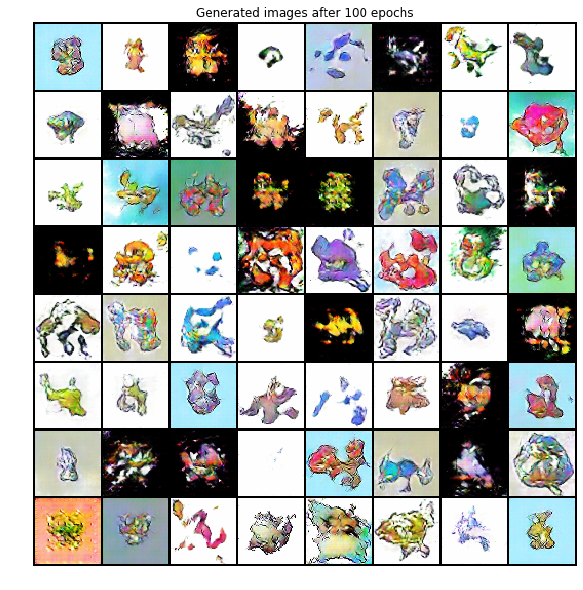

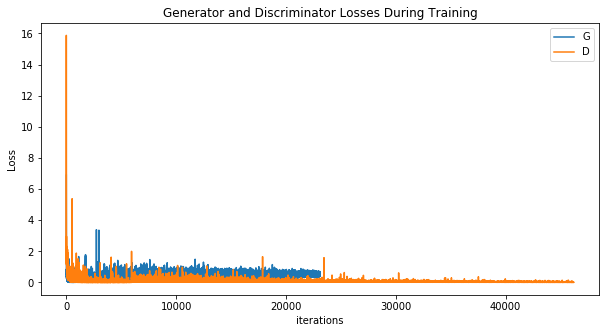

In [6]:
######################### Define Models
discriminator = Discriminator(ndf, nc).apply(weights_init).to(device)
generator = Generator(nz, ngf, nc).apply(weights_init).to(device)

######################### Loss & Optimizer
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
schedulerD = optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)
schedulerG = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)

######################### Train GAN
model = GAN(generator, discriminator, optimizerG, optimizerD, schedulerG, schedulerD)
model.train(dataloader, epochs, checkpoint_file)

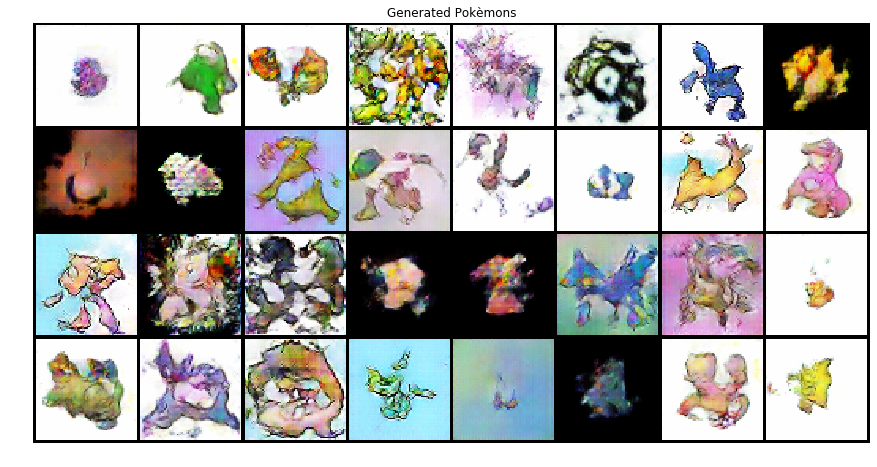

In [17]:
model.generate_pokemons(32)